## Analysing a single run

In [ ]:
PATH = "E:/UF/ifwaste/output/gsua_test/run_0/"


In [80]:
import pandas as pd
df_bought = pd.read_csv( PATH + 'bought.csv')
df_eaten = pd.read_csv( PATH + 'eaten.csv')
df_wasted = pd.read_csv( PATH + 'wasted.csv')
df_left = pd.read_csv(PATH + "still_have.csv")
df_daily = pd.read_csv(PATH + "daily.csv")

## LOC tests

In [18]:
import os
import pandas as pd

def setup_dataset_with_concern(path, foldername, filter_is_serving_based):
    # Get the list of subfolder paths
    subfolder_paths = [os.path.join(path, foldername, subfolder) for subfolder in os.listdir(os.path.join(path, foldername))]
    
    # Create individual data frames for each unique file name
    dataframes = {}
    for subfolder_path in subfolder_paths:
        run = os.path.basename(subfolder_path).split('_')[1]  # Extract run from folder name (e.g. run_0)
        file_paths = [os.path.join(subfolder_path, file) for file in os.listdir(subfolder_path) if file.endswith('.csv')]
        
        for file_path in file_paths:
            # Reading the CSV file into a DataFrame
            df = pd.read_csv(file_path)
            df['Run'] = run  # Add Run column based on folder name
            
            # Add to dictionary using file name (without extension) as the key
            key = os.path.splitext(os.path.basename(file_path))[0]
            if key in dataframes:
                dataframes[key] = pd.concat([dataframes[key], df])
            else:
                dataframes[key] = df
    
    # Create Group column in config and wasted
    if 'config' in dataframes and 'wasted' in dataframes:
        config_df = dataframes['config']
        config_df['Group'] = config_df['Run'].astype(str) + "_" + config_df['House'].astype(str)
        
        wasted_df = dataframes['wasted']
        wasted_df['Group'] = wasted_df['Run'].astype(str) + "_" + wasted_df['House'].astype(str)
        
        # Merge LevelOfConcern from config into wasted based on Group
        wasted_df = wasted_df.merge(config_df[['Group', 'LvlOfConcern']], on='Group', how='left')
        
        # Apply filtering if necessary
        if filter_is_serving_based:
            serving_runs_houses = config_df.loc[config_df['IsServingBased'], ['Run', 'House', "LvlOfConcern"]]
            wasted_df = wasted_df[
                (wasted_df['Run'].isin(serving_runs_houses['Run'])) &
                (wasted_df['House'].isin(serving_runs_houses['House']))
            ]
        
        waste_hh_day = wasted_df.groupby(['Group', 'Day Wasted', "LvlOfConcern"])['Kg'].sum().reset_index()
        
        return waste_hh_day
    else:
        raise ValueError("Required data ('config' or 'wasted') is missing from the dataset")

PATH = "E:/UF/archive/01_paper/data/"

df_waste_6_c = setup_dataset_with_concern(PATH,"6_kids/",True)
df_waste_4_c = setup_dataset_with_concern(PATH,"4_kids/",True)
df_waste_2_c = setup_dataset_with_concern(PATH,"2_kids/",True)
df_waste_0_c = setup_dataset_with_concern(PATH,"0_kids/",True)


In [19]:
df_waste_4_c.head()

,Group,Day Wasted,LvlOfConcern,Kg
0,0_0,0,0.289184,0.474649
1,0_0,1,0.289184,1.592845
2,0_0,2,0.289184,1.404275
3,0_0,3,0.289184,5.739757
4,0_0,4,0.289184,1.760807


C:\Users\helen\AppData\Local\Temp\ipykernel_58784\806683892.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')  # Choose a color map


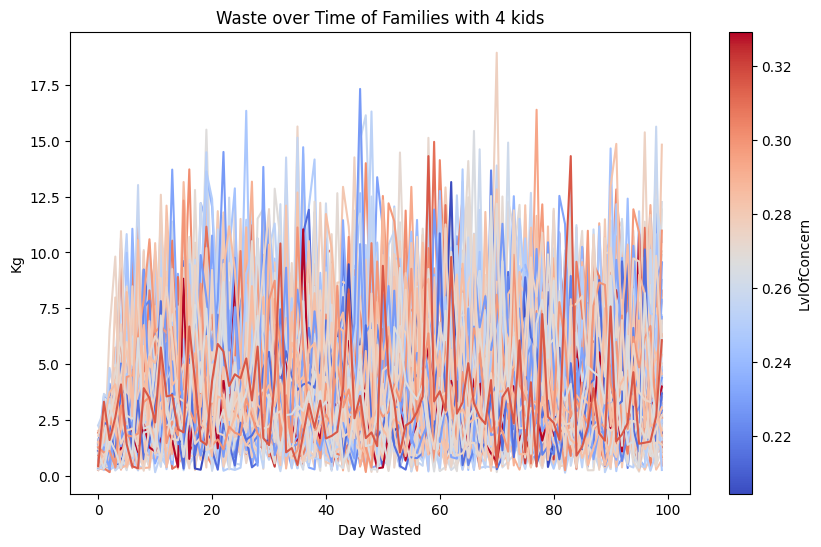

In [26]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd

# Normalize the level of concern to map it to color intensity
norm = mcolors.Normalize(vmin=df_waste_4_c['LvlOfConcern'].min(), vmax=df_waste_4_c['LvlOfConcern'].max())
cmap = cm.get_cmap('coolwarm')  # Choose a color map

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each group with color intensity based on LvlOfConcern
for group, group_data in df_waste_4_c.groupby('Group'):
    # Get color for the group's LvlOfConcern
    color = cmap(norm(group_data['LvlOfConcern'].mean()))  # Mean concern level for simplicity
    
    # Plot the line for this group
    ax.plot(group_data['Day Wasted'], group_data['Kg'], color=color)

# Add color bar for level of concern
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(df_waste_4_c['LvlOfConcern'])  # Associate with the level of concern data
cbar = plt.colorbar(sm, ax=ax)  # Create the color bar
cbar.set_label('LvlOfConcern')

# Customize plot labels and title
plt.xlabel('Day Wasted')
plt.ylabel('Kg')
plt.title('Waste over time of families with 4 kids')


# Show the plot
plt.show()


In [31]:
df_waste_4_c.head()

,Group,Day Wasted,LvlOfConcern,Kg
0,0_0,0,0.289184,0.474649
1,0_0,1,0.289184,1.592845
2,0_0,2,0.289184,1.404275
3,0_0,3,0.289184,5.739757
4,0_0,4,0.289184,1.760807


In [43]:
# Group by 'Group' and calculate the average Kg for each group, while preserving 'LvlOfConcern'
grouped_data = df_waste_4_c.groupby('Group').agg(
    Avg_Waste=('Kg', 'mean'),
    LvlOfConcern=('LvlOfConcern', 'first')  # Assuming the LvlOfConcern is the same for the group
).reset_index()

# Merge the average waste and level of concern back into the original DataFrame
data = pd.merge(df_waste_4_c, grouped_data, on='Group')
print(data.columns)
data = data.drop(columns=["LvlOfConcern_x"])
data = data.rename(columns={"LvlOfConcern_y": "LvlOfConcern"})

Index(['Group', 'Day Wasted', 'LvlOfConcern_x', 'Kg', 'Avg_Waste',
       'LvlOfConcern_y'],
      dtype='object')


In [44]:
data.head()

,Group,Day Wasted,Kg,Avg_Waste,LvlOfConcern
0,0_0,0,0.474649,3.902809,0.289184
1,0_0,1,1.592845,3.902809,0.289184
2,0_0,2,1.404275,3.902809,0.289184
3,0_0,3,5.739757,3.902809,0.289184
4,0_0,4,1.760807,3.902809,0.289184


Text(0.5, 1.0, '4 kids')

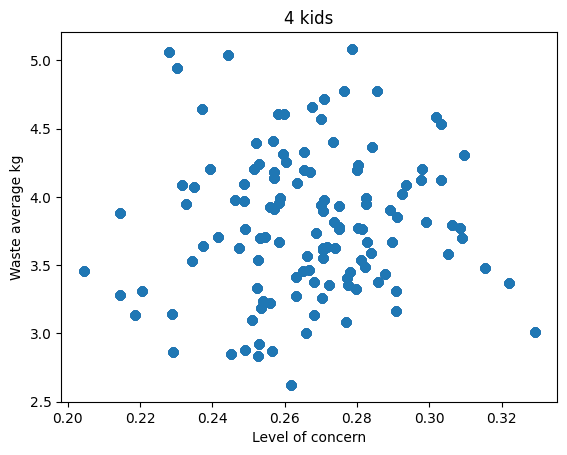

In [47]:
plt.scatter(data["LvlOfConcern"], data["Avg_Waste"])

# Customize plot labels and title
plt.xlabel('Level of concern')
plt.ylabel('Waste average kg')
plt.title('4 kids')

## Biomass Check


### Sanity Check 1: Biomass is 0: bought - (eaten + wasted + remaining) = 0


In [54]:
print("bought total kg: ", df_bought["Kg"].sum())
print("eaten total kg: ", df_eaten["Kg"].sum())
print("wasted total kg: ", df_wasted["Kg"].sum())

max_day = df_left["Day"].max()
left = df_left[df_left["Day"] == max_day]["Kg"].sum()
print("left last day in kg: ", left)
diff = df_bought["Kg"].sum() - (df_eaten["Kg"].sum() + df_wasted["Kg"].sum() + left)

print("bought - consumed: ", diff)

bought total kg:  728.432
eaten total kg:  565.8374203577729
wasted total kg:  143.54730802504787
left last day in kg:  19.047271617179195
bought - consumed:  1.1368683772161603e-13


In [55]:
#nach 2 Wochen
for (df, column_name) in zip([df_bought, df_eaten, df_wasted], ["Day Bought", "Day Eaten", "Day Wasted"]):

    daily_kg_sum = df[df[column_name] >= 14].groupby(column_name)['Kg'].sum()
    max_kg = daily_kg_sum.max()
    min_kg = daily_kg_sum.min()

    # Display the results
    print(column_name)    
    print("Minimum daily Kg:\t\t", min_kg)  
    print("Maximum daily Kg:\t\t", max_kg)
    print("Summed daily Kg, per person:\t", daily_kg_sum.sum()/(len(daily_kg_sum)*4), "\n")


max_day = df_left["Day"].max()
left = df_left[df_left["Day"] == max_day]["Kg"].sum()
print("left kg\t\t\t\t", left)
#unit test : > 0
# diff < delta

Day Bought
Minimum daily Kg:		 5.48
Maximum daily Kg:		 38.024
Summed daily Kg, per person:	 3.682785714285714 

Day Eaten
Minimum daily Kg:		 1.914060202267489
Maximum daily Kg:		 6.557596459724258
Summed daily Kg, per person:	 1.4034346462369305 

Day Wasted
Minimum daily Kg:		 0.2619397977325109
Maximum daily Kg:		 4.932468731014865
Summed daily Kg, per person:	 0.3663579061333532 

left kg				 19.047271617179195


# Behavior values

#### Calculate Frequency of Behavior values

In [81]:
QC = df_daily["QuickCook"].sum()
QS = df_daily["QuickShop"].sum()
Cooked = df_daily["Cooked"].sum()
Leftover = df_daily["AteLeftOvers"].sum()
hasIng = df_daily["Enough_ing"].sum()
hasTime = df_daily["Enough_time"].sum()

print(f"Hadtime: {hasTime}, HadIng: {hasIng}, Quickcook: {QC}, Cooked: {Cooked}, Leftover: {Leftover}, Quickshop: {QS}")
#unit cannot cook more than days - max(hadtime, hading)

Hadtime: 71, HadIng: 64, Quickcook: 56, Cooked: 44, Leftover: 98, Quickshop: 33


LOC 01: Hadtime: 71, HadIng: 64, Quickcook: 56, Cooked 44, Leftover: 98, Quickshop: 33

LOC 09: Hadtime: 86, HadIng: 61, Quickcook: 68, Cooked: 32, Leftover: 89, Quickshop: 24


#### Calculate Permutations of Behavior values

In [87]:
import pandas as pd

# Select only the desired columns
columns = ["Enough_time", "Enough_ing", "Cooked", "QuickCook", "AteLeftOvers", "QuickShop"]
df_filtered = df_daily[columns].copy()  # Create a copy to avoid the SettingWithCopyWarning

# Create a new column that represents the permutation of activities
df_filtered['Time,Ing,C,QC,LO,QS'] = df_filtered.apply(lambda row: tuple(row), axis=1)

# Count the occurrences of each permutation
permutation_counts = df_filtered['Time,Ing,C,QC,LO,QS'].value_counts()

# Convert to DataFrame for better readability
permutation_counts_df = permutation_counts.reset_index()
permutation_counts_df.columns = ['Time,Ing,C,QC,LO,QS', 'Count']

# Display the permutation counts
print(permutation_counts_df)


  Time,Ing,C,QC,LO,QS  Count
0  (1, 1, 1, 0, 1, 0)     43
1  (1, 0, 0, 1, 1, 1)     20
2  (0, 1, 0, 1, 1, 0)     17
3  (0, 0, 0, 1, 1, 1)     12
4  (1, 0, 0, 1, 1, 0)      3
5  (1, 1, 0, 1, 1, 0)      3
6  (1, 0, 0, 1, 0, 1)      1
7  (1, 1, 1, 0, 0, 0)      1


01   Time,Ing,C,QC,LO,QS  Count
0  (1, 1, 1, 0, 1, 0)     43
1  (1, 0, 0, 1, 1, 1)     20
2  (0, 1, 0, 1, 1, 0)     17
3  (0, 0, 0, 1, 1, 1)     12
4  (1, 0, 0, 1, 1, 0)      3
5  (1, 1, 0, 1, 1, 0)      3
6  (1, 0, 0, 1, 0, 1)      1
7  (1, 1, 1, 0, 0, 0)      1

09 Time,Ing,C,QC,LO,QS  Count
  
0  (1, 1, 1, 0, 1, 0)     27
1  (1, 1, 0, 1, 1, 0)     20
2  (1, 0, 0, 1, 1, 1)     17
3  (1, 0, 0, 1, 1, 0)     14
4  (0, 1, 0, 1, 1, 0)      6
5  (1, 1, 1, 0, 0, 0)      5
6  (0, 0, 0, 1, 1, 1)      4
7  (0, 1, 0, 1, 0, 0)      3
8  (1, 0, 0, 1, 0, 1)      3
9  (0, 0, 0, 1, 1, 0)      1

#### Plotting the behavior variables over time

<Figure size 1200x600 with 0 Axes>

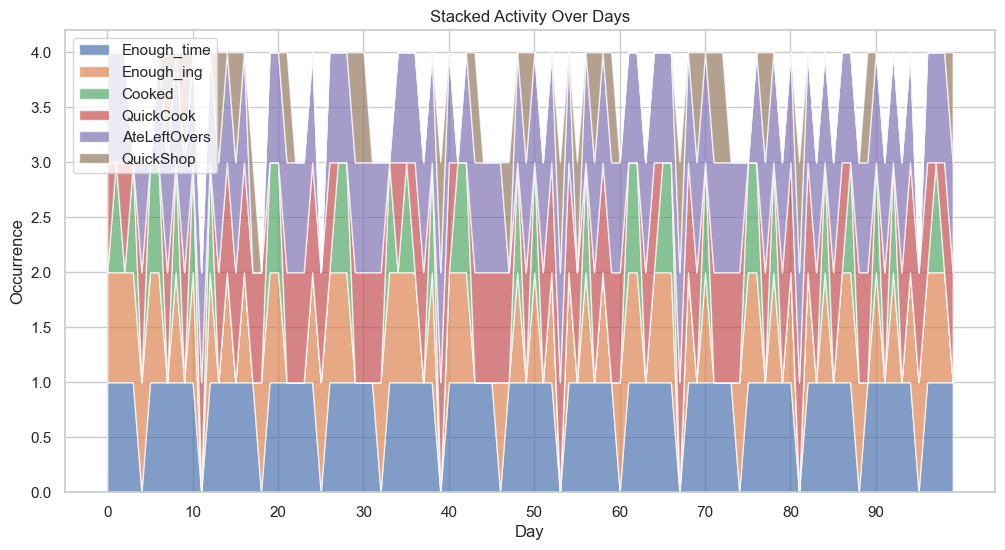

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for seaborn
sns.set(style="whitegrid")

# Plotting each activity as a separate line
plt.figure(figsize=(12, 6))
columns =  ["Enough_time", "Enough_ing", "Cooked", "QuickCook", "AteLeftOvers","QuickShop"]


# Plotting as a stacked area plot
plt.figure(figsize=(12, 6))

# Stacked area plot to show cumulative events
plt.stackplot(df_daily['Day'], [df_daily[col] for col in columns], labels=columns, alpha=0.7)

plt.title('Stacked Activity Over Days')
plt.xlabel('Day')
plt.xticks(ticks=range(0, df_daily['Day'].max() + 1, 10))
plt.ylabel('Occurrence')
plt.legend(loc='upper left')
plt.show()


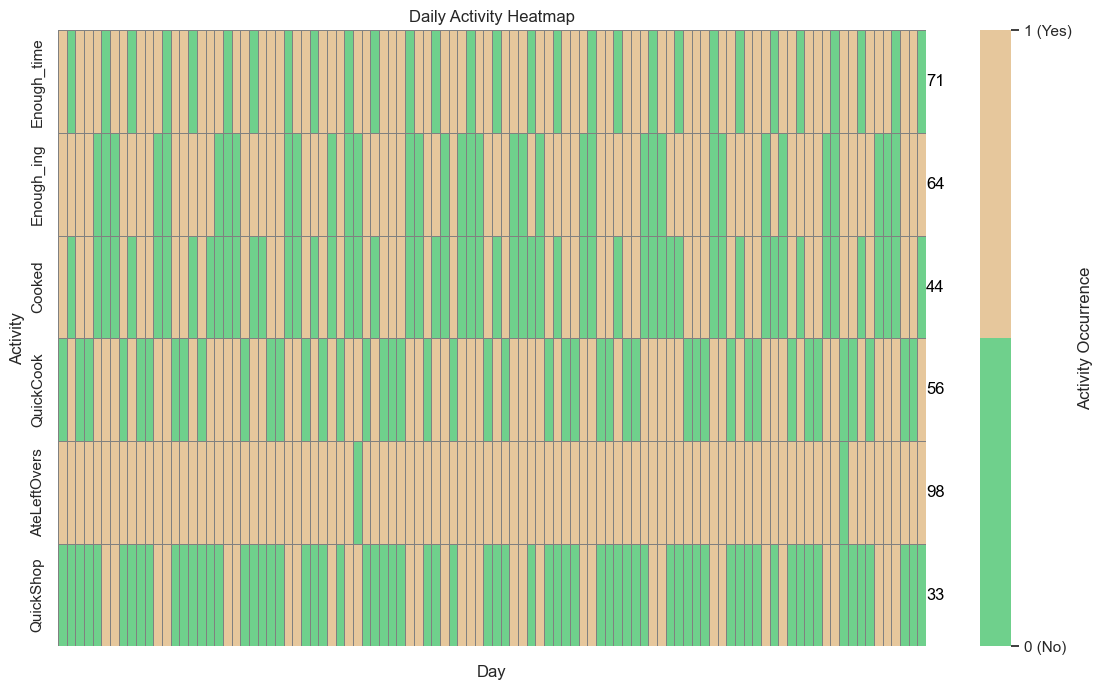

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Ensure df_daily is loaded and processed as per your data

# Select only the desired columns
columns = ["Enough_time", "Enough_ing", "Cooked", "QuickCook", "AteLeftOvers", "QuickShop"]
df_filtered = df_daily[columns]

# Set 'Day' as index if not already set
if 'Day' in df_filtered.columns:
    df_filtered.set_index('Day', inplace=True)

# Calculate the sum of each row (activity) and add it as a new column
row_sums = df_filtered.sum(axis=0)  # Sum each row

# Define a binary colormap with two distinct colors
binary_cmap = ListedColormap(["#6FD08C", "#E6C79C"])

# Plotting Heatmap with binary colors
plt.figure(figsize=(14, 8))  # Increased width to accommodate the new column
ax = sns.heatmap(
    df_filtered.T,
    cmap=binary_cmap,            # Use the binary colormap
    cbar=True,                   # Enable the color bar (legend)
    linewidths=0.5,
    linecolor='gray',
    vmin=0, vmax=1,              # Set limits to binary values
    cbar_kws={'ticks': [0, 1], 'label': 'Activity Occurrence'}  # Set binary ticks
)

# Customize the color bar to show only binary values
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['0 (No)', '1 (Yes)'])

# Display the sum values on the right side of the heatmap
for i, sum_value in enumerate(row_sums):
    ax.text(df_filtered.shape[0], i + 0.5, f'{sum_value:.0f}', ha='left', va='center', color='black')


plt.title('Daily Activity Heatmap')
plt.xlabel('Day')
plt.ylabel('Activity')
plt.xticks(range(0, df_filtered.index.max() + 1, 10))  # Show every 10th day on the x-axis
plt.show()

#E6C79C
#CDDFA0
#6FD08C
#7B9EA8
#78586F


  Time,Ing,C,QC,LO,QS  Count
0  (1, 1, 1, 0, 1, 0)     43
1  (1, 0, 0, 1, 1, 1)     20
2  (0, 1, 0, 1, 1, 0)     17
3  (0, 0, 0, 1, 1, 1)     12
4  (1, 0, 0, 1, 1, 0)      3
5  (1, 1, 0, 1, 1, 0)      3
6  (1, 0, 0, 1, 0, 1)      1
7  (1, 1, 1, 0, 0, 0)      1


C:\Users\helen\AppData\Local\Temp\ipykernel_1832\3034891711.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


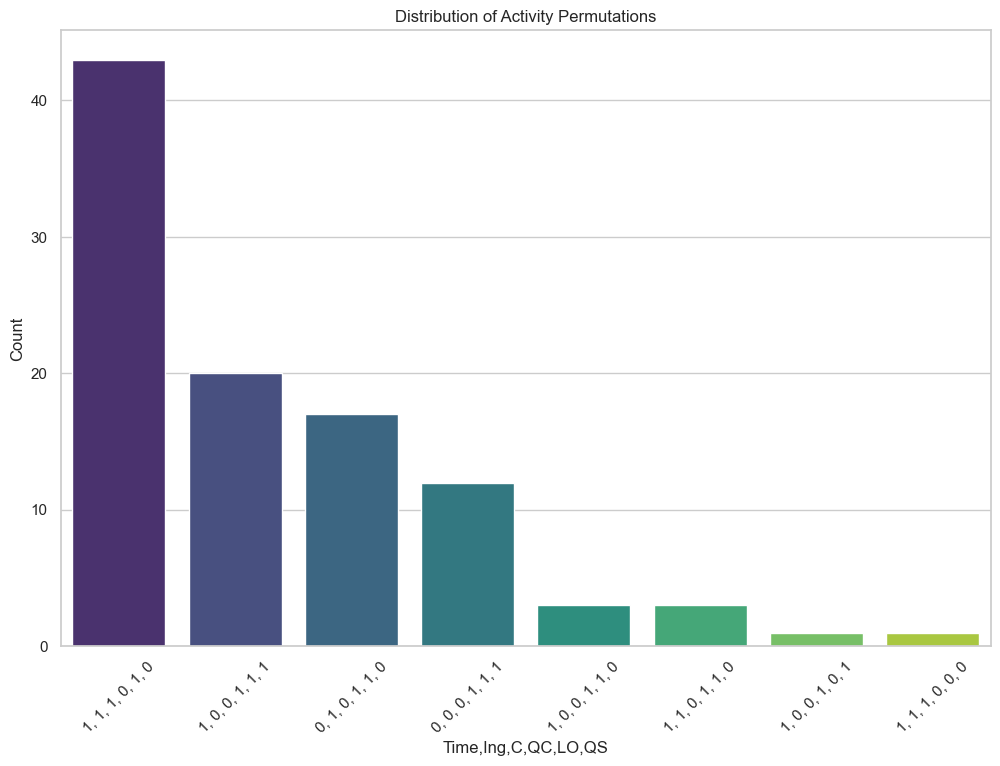

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#run permutation_counts_df first


# Convert permutations to a readable format for plotting
permutation_counts_df["Time,Ing,C,QC,LO,QS"] = permutation_counts_df["Time,Ing,C,QC,LO,QS"].apply(lambda x: ', '.join(map(str, x)))

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(
    x="Time,Ing,C,QC,LO,QS",
    y='Count',
    data=permutation_counts_df,
    palette='viridis'
)


plt.title('Distribution of Activity Permutations')
plt.ylabel('Count')
plt.xlabel("Time,Ing,C,QC,LO,QS")
plt.xticks(rotation=45)  # Rotate x labels if needed for better readability
plt.show()
